In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
sns.set(rc={'figure.figsize':(6,8)}) 

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

from sklearn.preprocessing import LabelEncoder 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn import metrics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import SCORERS
import re

import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Functions

In [2]:
def cleanTxt(txt):
    txt = txt.lower()
    txt = re.sub(r'RT[\s]+', '', txt) #removing RT
    txt = re.sub(r'[^\w\s]','', txt) #remove everything except words and space
    txt = re.sub(r'_','', txt) #how to remove underscore as well
    txt = re.sub('\r\n', '', txt)
    txt = re.sub('amp', '', txt) # removing ampersand
    if 'https' in txt: # removing hyperlinks 
        pos = txt.find('https')
        txt = txt[:pos]
    return txt

In [3]:
def stopWords(txt): 
    txt_lst = txt.split(" ")
    txt_lst = [word for word in txt_lst if word not in stopwords.words('english')]
    txt_lst = [wnet.lemmatize(word) for word in txt_lst]
    txt_lst = [word for word in txt_lst if word != '']
    txt_lst = [word for word in txt_lst if word != 'u0001f449'] # indicates back hand emoji pointing right
    txt_lst = [word for word in txt_lst if word != 'surveillance']
    txt_lst = [word for word in txt_lst if word != '\r\n']
    txt_lst = [word for word in txt_lst if word != 'u']
    return " ".join(txt_lst)

In [4]:
def evaluate_k_kmeans_inertia(k):
    print(f"running Kmeans with k={k}")
    estimator_kmeans = KMeans(random_state=42, n_clusters=k)
    estimator_kmeans.fit(desc_vec)
    return estimator_kmeans.inertia_

In [5]:
!pip install pycountry

In [8]:
!pip install pycountry
def findCountry(txt):
    loc = []
    for c in pycountry.countries:
        if c.name in txt:
            return c.name
        elif txt != 'global':
            return 'Unknown'

In [9]:
def cluster_summary(ci, df):
    cluster = df[df.cluster_id==ci]
    cluster_summary = cluster[categorical_data.columns].mode().to_dict(orient="records")[0]
    cluster_summary.update(cluster.mean().to_dict())
    return cluster_summary

In [10]:
def cluster_comparison(*cluster_ids):
    summaries = []
    for cluster_id in cluster_ids:
        summaries.append(cluster_summary(cluster_id, df2))
    return pd.DataFrame(summaries).set_index("cluster_id").T

In [11]:
def kmeans_cluster(df, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['Cluster'] = clusters
    return cluster_results

In [14]:
def graph_summary_clustering(results):
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    cluster_summary = cluster_summary.drop(["Count"], axis=1).set_index("Cluster")
    return cluster_summary[sorted(cluster_summary.columns)]

# Surveillance Tweets

In [15]:
data = pd.read_csv('surveillance.csv')

In [16]:
data = data.drop_duplicates('text')
data.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url
0,x1086388569294471172,x1406987671000563719,2021-06-21 14:49:35,hypercursor,@floridamancode @EcoTechBro It’s the successfu...,Twitter for iPhone,176,x1406984343604666368,x1266369503442554894,floridamancode,...,2216,3031,2019-01-18 22:23:13,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/10863885...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1375243020...
1,x1068338071702097920,x1406987628948324358,2021-06-21 14:49:25,waiwai__LA,"@engineers_feed Check the evacuation route, wa...",Twitter Web App,144,x1406846131603185664,x3429950987,engineers_feed,...,9099,23234,2018-11-30 02:56:59,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/10683380...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1368471393...
2,x38639718,x1406987333057003525,2021-06-21 14:48:15,lise_latulippe,The Toronto Police Service’s forensic identifi...,Twitter Web App,237,NaN,NaN,NaN,...,327958,383,2009-05-08 10:12:38,False,http://t.co/TDlDxXDMe8,http://linkis.com/blogspot.com/Nhf1O,NaN,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9780331515...
3,x38639718,x1405496093966798855,2021-06-17 12:02:36,lise_latulippe,Trump had launched so many attacks against the...,Twitter Web App,223,NaN,NaN,NaN,...,327958,383,2009-05-08 10:12:38,False,http://t.co/TDlDxXDMe8,http://linkis.com/blogspot.com/Nhf1O,NaN,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9780331515...
4,x38639718,x1406934080529309697,2021-06-21 11:16:39,lise_latulippe,Police released surveillance video on Sunday o...,Twitter Web App,271,NaN,NaN,NaN,...,327958,383,2009-05-08 10:12:38,False,http://t.co/TDlDxXDMe8,http://linkis.com/blogspot.com/Nhf1O,NaN,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9780331515...


In [18]:
data.user_id.nunique()

13171

In [19]:
data.shape

(17330, 90)

# Identifying Columns
## Cleaning Data

In [20]:
ident = data[["verified", "lang", "location", "followers_count", "description", "user_id"]] # can always change later
ident = ident.drop_duplicates()

In [21]:
ident = ident.dropna()
ident.head()

,verified,lang,location,followers_count,description,user_id
0,False,en,this;,108,"an all around good egg, cybernetically speakin...",x1086388569294471172
2,False,en,Brampton.Ont,2187,Trying to change the way patient complaints ar...,x38639718
18,False,en,Australia,873,"I like design. The photo is at Cobh harbour, ...",x587118793
20,False,en,"Riverdale Park, MD",1711,"Cook Organic, Not the Planet! Political Direct...",x19993673
22,False,en,"London, England",3842,Socialist till the day I die..married mum of 3...,x1251921456847519751


In [22]:
ident['description'] = ident['description'].apply(cleanTxt)

ident.head()

,verified,lang,location,followers_count,description,user_id
0,False,en,this;,108,an all around good egg cybernetically speaking...,x1086388569294471172
2,False,en,Brampton.Ont,2187,trying to change the way patient complaints ar...,x38639718
18,False,en,Australia,873,i like design the photo is at cobh harbour ir...,x587118793
20,False,en,"Riverdale Park, MD",1711,cook organic not the planet political director...,x19993673
22,False,en,"London, England",3842,socialist till the day i diemarried mum of 3 m...,x1251921456847519751


In [23]:
wnet = WordNetLemmatizer()
ident['description'] = ident['description'].apply(stopWords)

In [24]:
desc = ident[['description']]
desc.head()

,description
0,around good egg cybernetically speaking kegg a...
2,trying change way patient complaint handle htt...
18,like design photo cobh harbour ireland
20,cook organic planet political director organic...
22,socialist till day diemarried mum 3 pure hatre...


In [25]:
desc_lst = []
for row in desc['description']:
    desc_lst.append(row)

desc_lst[:5] # need to make into a list so the vectorizer will work

['around good egg cybernetically speaking kegg allusion bwo intended',
 'trying change way patient complaint handle httptcooabq9nup',
 'like design photo cobh harbour ireland',
 'cook organic planet political director organicconsumer farmer rancher greennewdeal podcast host regenerationin',
 'socialist till day diemarried mum 3 pure hatred tory burn deepno dm please solidarity always u270a']

In [26]:
tv = TfidfVectorizer(
binary = True, norm = None,
use_idf = False, smooth_idf = False,
lowercase = True, stop_words = None,
min_df = 1, max_df = 1.0, max_features = None, ngram_range = (1,1))

desc_vec = pd.DataFrame(tv.fit_transform(desc_lst).toarray(), columns = tv.get_feature_names())
desc_vec.head()

,00,000,0000000175420286,000000032497833x,001,002,007,01480,01482,01604,...,évolutions,ísafjörðuru0001f3ddufe0fu0001f30au0001f427own,óta,ögrenme,ögrenmenin,über,überbringer,überwacht,œv,ƒsu044f
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Making List of Words

In [27]:
desc_words = []

for row in desc['description']:
    for word in str(row).split(" "):
        desc_words.append(word)
        
desc_words[:5]

['around', 'good', 'egg', 'cybernetically', 'speaking']

In [28]:
from nltk.probability import FreqDist
fdist_desc = FreqDist()
for word in desc_words:
    fdist_desc[word]+=1
fdist_desc

FreqDist({'news': 759, 'security': 324, 'health': 315, 'world': 306, 'tweet': 302, 'life': 287, 'love': 284, 'right': 271, 'tech': 252, 'view': 249, ...})

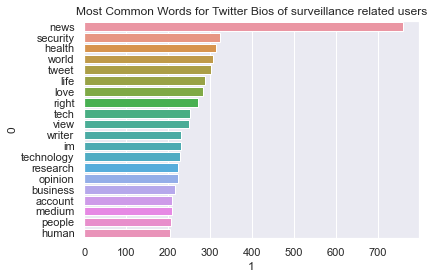

In [30]:
freq_data_desc = pd.DataFrame.from_dict(fdist_desc.most_common(20))
rel = sns.barplot(data = freq_data_desc, x = 1, y = 0).set(title='Most Common Words for Twitter Bios of surveillance related users')


In [32]:
most_common_desc = []

for key in fdist_desc.most_common(20):
    most_common_desc.append(key[0])
    
most_common_desc

['news',
 'security',
 'health',
 'world',
 'tweet',
 'life',
 'love',
 'right',
 'tech',
 'view',
 'writer',
 'im',
 'technology',
 'research',
 'opinion',
 'business',
 'account',
 'medium',
 'people',
 'human']

## Clustering by description
### This helps us identify the different kinds of accounts that are tweeting about this topic.

In [33]:
%%time 
range_k = [i for i in range(1, 9)]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k)

running Kmeans with k=1
running Kmeans with k=2
running Kmeans with k=3
running Kmeans with k=4
running Kmeans with k=5
running Kmeans with k=6
running Kmeans with k=7
running Kmeans with k=8
Wall time: 9min 35s


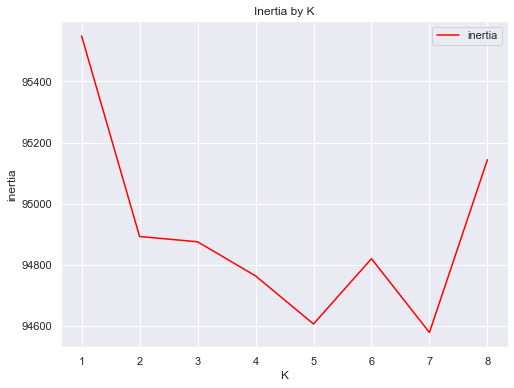

In [34]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend();


### Cluster Analysis

In [35]:
estimator_kmeans = KMeans(random_state=42, n_clusters=6)

estimator_kmeans.fit(desc_vec)

KMeans(n_clusters=6, random_state=42)

In [36]:
desc_vec["cluster_id"] = estimator_kmeans.labels_
desc_vec.head()

,00,000,0000000175420286,000000032497833x,001,002,007,01480,01482,01604,...,ísafjörðuru0001f3ddufe0fu0001f30au0001f427own,óta,ögrenme,ögrenmenin,über,überbringer,überwacht,œv,ƒsu044f,cluster_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [37]:
desc_clusters = desc_vec.groupby('cluster_id').sum()
desc_clusters.head()

,00,000,0000000175420286,000000032497833x,001,002,007,01480,01482,01604,...,évolutions,ísafjörðuru0001f3ddufe0fu0001f30au0001f427own,óta,ögrenme,ögrenmenin,über,überbringer,überwacht,œv,ƒsu044f
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
desc_clusters_20 = desc_clusters[['news',
 'security',
 'health',
 'world',
 'tweet',
 'life',
 'love',
 'right',
 'tech',
 'view',
 'writer',
 'im',
 'technology',
 'research',
 'opinion',
 'business',
 'account',
 'medium',
 'people',
 'human']]

desc_clusters_20



,news,security,health,world,tweet,life,love,right,tech,view,writer,im,technology,research,opinion,business,account,medium,people,human
cluster_id,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,618.0,19.0,11.0,50.0,24.0,7.0,3.0,6.0,31.0,15.0,8.0,5.0,26.0,8.0,21.0,31.0,25.0,39.0,5.0,7.0
2,0.0,264.0,243.0,248.0,270.0,264.0,260.0,238.0,205.0,230.0,220.0,193.0,193.0,208.0,199.0,174.0,177.0,160.0,190.0,187.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


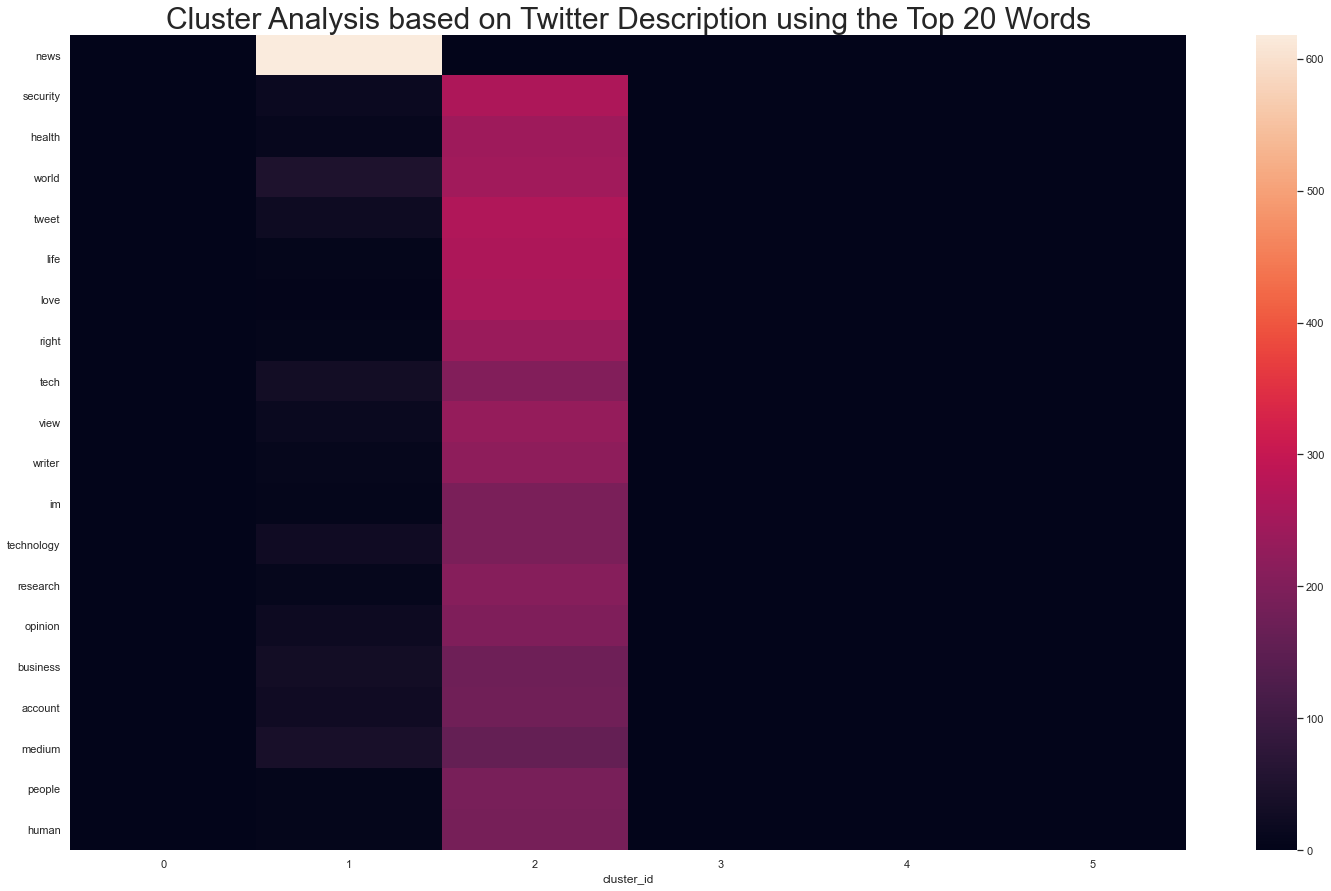

In [43]:
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(desc_clusters_20.transpose(), annot=False)
plt.title("Cluster Analysis based on Twitter Description using the Top 20 Words", size = 30);

## Clustering on other columns

In [44]:
df2 = data[["created_at", "is_quote", "retweet_count", "location", "followers_count", "friends_count", "listed_count", "account_created_at", "verified"]][:3000]
df2.head() # remove is_retweet and protected, no variance

,created_at,is_quote,retweet_count,location,followers_count,friends_count,listed_count,account_created_at,verified
0,2021-06-21 14:49:35,False,0,this;,108,197,0,2019-01-18 22:23:13,False
1,2021-06-21 14:49:25,False,0,NaN,97,215,0,2018-11-30 02:56:59,False
2,2021-06-21 14:48:15,False,0,Brampton.Ont,2187,2037,26,2009-05-08 10:12:38,False
3,2021-06-17 12:02:36,False,0,Brampton.Ont,2187,2037,26,2009-05-08 10:12:38,False
4,2021-06-21 11:16:39,False,0,Brampton.Ont,2187,2037,26,2009-05-08 10:12:38,False


In [45]:
from datetime import datetime, date
df2[["created_at"]] = df2[["created_at"]].apply(pd.to_datetime)

In [46]:
df2['year_account_created'] = pd.DatetimeIndex(df2["account_created_at"]).year
df2 = df2.drop(["created_at", "account_created_at"], axis=1)
df2['year_account_created'] = df2["year_account_created"].astype("category")
df2.head()

,is_quote,retweet_count,location,followers_count,friends_count,listed_count,verified,year_account_created
0,False,0,this;,108,197,0,False,2019
1,False,0,NaN,97,215,0,False,2018
2,False,0,Brampton.Ont,2187,2037,26,False,2009
3,False,0,Brampton.Ont,2187,2037,26,False,2009
4,False,0,Brampton.Ont,2187,2037,26,False,2009


In [47]:
df2 = df2.drop('location', axis = 1)

In [48]:
numerical_data = df2.select_dtypes(np.number)
categorical_data = df2.drop(numerical_data, axis = 1)

### Processing Data

In [49]:
from sklearn.preprocessing import MinMaxScaler

numerical_data_normalized = MinMaxScaler().fit_transform(numerical_data) # this line scales our data

numerical_data_normalized = pd.DataFrame(              #this pops it back in data frame format 
    numerical_data_normalized,
    columns=numerical_data.columns) 

numerical_data_normalized.head()

,retweet_count,followers_count,friends_count,listed_count
0,0.0,0.000011,0.000426,0.000000
1,0.0,0.000010,0.000465,0.000000
2,0.0,0.000217,0.004407,0.000543
3,0.0,0.000217,0.004407,0.000543
4,0.0,0.000217,0.004407,0.000543


In [50]:
categorical_data_codified = pd.get_dummies(
                                    categorical_data, 
                                    drop_first=True,
                                    dtype="int64"
).reset_index()
categorical_data_codified.head()

,index,is_quote,verified,year_account_created_2007,year_account_created_2008,year_account_created_2009,year_account_created_2010,year_account_created_2011,year_account_created_2012,year_account_created_2013,year_account_created_2014,year_account_created_2015,year_account_created_2016,year_account_created_2017,year_account_created_2018,year_account_created_2019,year_account_created_2020,year_account_created_2021
0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,False,False,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2,False,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,3,False,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,4,False,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
categorical_data_codified = categorical_data_codified.drop('index', axis = 1)


In [52]:
df2_processed = pd.concat([
                            numerical_data_normalized,
                            categorical_data_codified
                        ], axis=1
).reset_index()

In [53]:
df2_processed = df2_processed.drop('index', axis = 1)


In [54]:
df2_processed.head()


,retweet_count,followers_count,friends_count,listed_count,is_quote,verified,year_account_created_2007,year_account_created_2008,year_account_created_2009,year_account_created_2010,...,year_account_created_2012,year_account_created_2013,year_account_created_2014,year_account_created_2015,year_account_created_2016,year_account_created_2017,year_account_created_2018,year_account_created_2019,year_account_created_2020,year_account_created_2021
0,0.0,0.000011,0.000426,0.000000,False,False,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.0,0.000010,0.000465,0.000000,False,False,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0.0,0.000217,0.004407,0.000543,False,False,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.000217,0.004407,0.000543,False,False,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.000217,0.004407,0.000543,False,False,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Finding K

In [ ]:
%%time 
range_k = [2, 3, 4, 5, 8, 10, 15, 20, 25, 30, 35]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend();

### Cluster Analysis

In [ ]:
estimator_kmeans = KMeans(random_state=42, n_clusters=15) 
estimator_kmeans.fit(df2_processed)

In [ ]:
df2["cluster_id"] = estimator_kmeans.labels_
df2.head()

In [ ]:
df2.cluster_id.value_counts()

In [ ]:
cluster_summary(1, df2)

In [ ]:
cluster_comparison(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14)

In [ ]:
cluster_results = kmeans_cluster(df2_processed, 10)
cluster_summary2 = graph_summary_clustering(cluster_results)

In [ ]:
cluster_summary2

<AxesSubplot:xlabel='Cluster'>

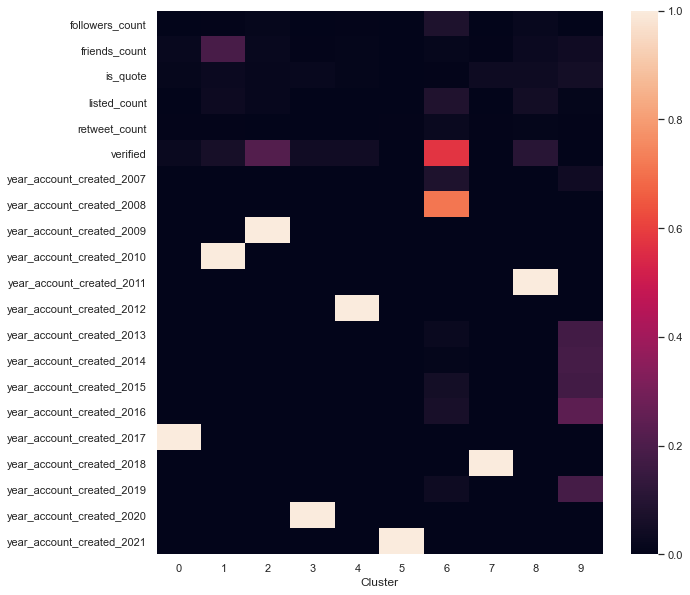

In [100]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cluster_summary2.transpose(), annot=False)
# the cluster looks better than the previous one on only the tweets